In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
plt.style.use('seaborn-v0_8')

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'Circular device test.csv',
 'curve_fit_Test.ipynb',
 'LMFit_Test.ipynb']

In [4]:
fullspectrum = pd.read_csv('Circular device test.csv', names=['wavenumber','absorption'])
fullspectrum.head()

,wavenumber,absorption
0,525.0337,0.280037
1,525.5158,0.280841
2,525.9979,0.281505
3,526.4800,0.282039
4,526.9622,0.282498


In [5]:
titleFonts = {'fontname' : 'Arial', 'fontsize' : 16}
axisFonts = {'fontname' : 'Arial', 'fontsize' : 14}

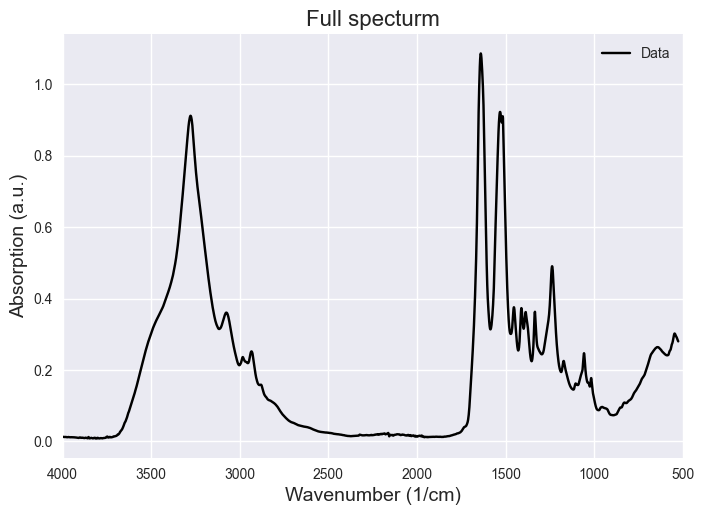

In [6]:
plt.plot(fullspectrum.wavenumber, fullspectrum.absorption, 'k-', label='Data')
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Full specturm', **titleFonts)
plt.grid(True)
plt.xlim([4000,500])
plt.legend()
plt.show()

# Separating Amide I band

In [7]:
amide_initial = 1580
amide_final = 1725

In [8]:
amide_band_limit = [amide_initial, amide_final]
print(amide_band_limit)

[1580, 1725]


In [9]:
def amide_band_data(data, *limits):
    low = limits[0]
    upp = limits[1]
    amide_data = pd.DataFrame()
    amide_data = data[(data['wavenumber'] >= low) &\
    (data['wavenumber'] <= upp)]
    amide_data.reset_index(drop=True, inplace=True)
    return amide_data

In [10]:
amide_data = amide_band_data(fullspectrum, *amide_band_limit)
amide_data.head()

,wavenumber,absorption
0,1580.404,0.321018
1,1580.886,0.319589
2,1581.369,0.318323
3,1581.851,0.317212
4,1582.333,0.316246


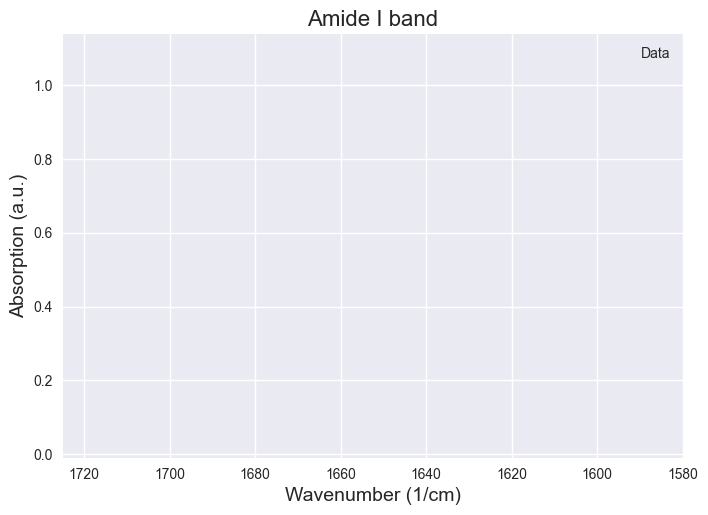

In [11]:
plt.plot(amide_data.wavenumber, amide_data.absorption, 'k+', label='Data')
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Amide I band', **titleFonts)
plt.grid(True)
plt.xlim([amide_band_limit[1], amide_band_limit[0]])
plt.legend()
plt.show()

# Savitzky-Golay filter

In [12]:
from scipy.signal import savgol_filter

In [13]:
def smooth_data(data):
    smoothed_absorption = savgol_filter(data['absorption'], window_length=50, polyorder=2)
    smoothed_data = pd.DataFrame()
    smoothed_data['wavenumber'] = data['wavenumber']
    smoothed_data['absorption'] = smoothed_absorption
    return smoothed_data

In [14]:
smoothed_data = smooth_data(amide_data)
smoothed_data.head()

,wavenumber,absorption
0,1580.404,0.319541
1,1580.886,0.318304
2,1581.369,0.317230
3,1581.851,0.316318
4,1582.333,0.315570


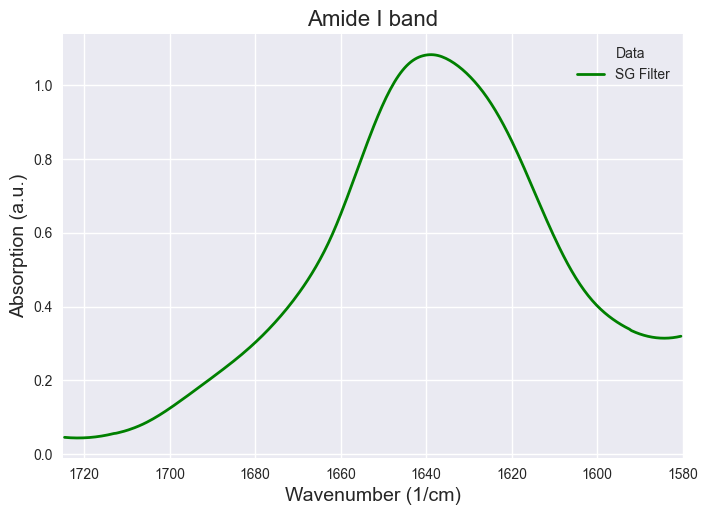

In [15]:
plt.plot(amide_data.wavenumber, amide_data.absorption, 'r+', alpha=0.8, label='Data')
plt.plot(smoothed_data.wavenumber, smoothed_data.absorption, 'g-', linewidth=2, label='SG Filter')
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Amide I band', **titleFonts)
plt.grid(True)
plt.xlim([amide_band_limit[1], amide_band_limit[0]])
plt.legend()
plt.show()

# Baseline correction

In [16]:
from peakutils import baseline

In [17]:
def baseline_subtraction(data):
    bl = baseline(data.absorption, deg=1)
    corrected_data = pd.DataFrame()
    corrected_data['wavenumber'] = data['wavenumber']
    corrected_data['absorption'] = data['absorption'] - bl
    return corrected_data

In [18]:
corrected_data = baseline_subtraction(smoothed_data)
corrected_data.head()

,wavenumber,absorption
0,1580.404,-0.004766
1,1580.886,-0.005032
2,1581.369,-0.005135
3,1581.851,-0.005076
4,1582.333,-0.004853


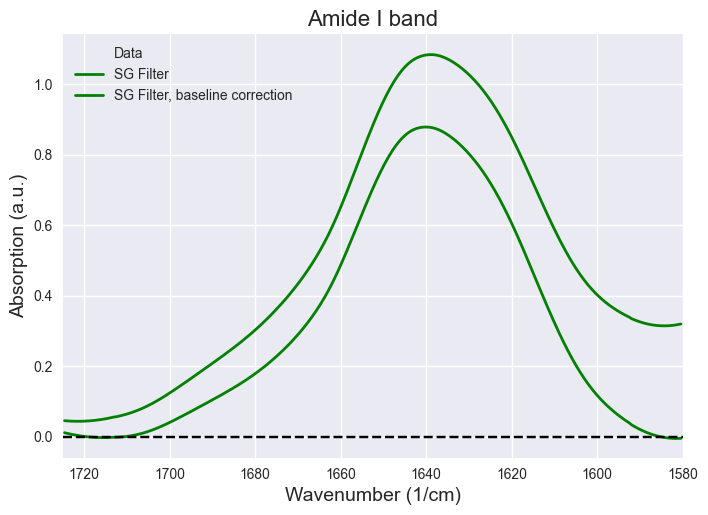

In [19]:
plt.plot(amide_data.wavenumber, amide_data.absorption, 'r+', alpha=0.8, label='Data')
plt.plot(smoothed_data.wavenumber, smoothed_data.absorption, 'g-', linewidth=2, label='SG Filter')
plt.plot(corrected_data.wavenumber, corrected_data.absorption, 'g-', linewidth=2, label='SG Filter, baseline correction')
plt.axhline(y=0, xmin=0, xmax=1, color='k', linestyle='--')
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Amide I band', **titleFonts)
plt.grid(True)
plt.xlim([amide_band_limit[1], amide_band_limit[0]])
plt.legend()
plt.show()

# Curve_fit

In [20]:
from scipy.optimize import curve_fit

In [21]:
def seven_gaussian(x, *params):
    assert len(params) == 21

    y = np.zeros_like(x)
    individual_peaks = []
    
    for i in range(len(peaks)):
        A = params[3*i]
        pk = params[3*i + 1]
        wid = params[3*i + 2]

        single = A * np.exp(-(x - pk)**2 / (2 * wid**2))
        y += single
        individual_peaks.append(single)
    return y, individual_peaks

In [22]:
def wrapFunction(x, *params):
    y, _ = seven_gaussian(x, *params)
    return y

In [23]:
peaks = [1609, 1621, 1631, 1650, 1673, 1695, 1703]

In [24]:
initial_guess = [
    1, 1609, 2,
    1, 1621, 2,
    1, 1631, 2,
    1, 1650, 2,
    1, 1673, 2,
    1, 1695, 2,
    1, 1703, 2,
]

In [25]:
print(initial_guess)

[1, 1609, 2, 1, 1621, 2, 1, 1631, 2, 1, 1650, 2, 1, 1673, 2, 1, 1695, 2, 1, 1703, 2]


In [26]:
popt, pcov = curve_fit(wrapFunction, corrected_data.wavenumber, corrected_data.absorption, \
                      p0=initial_guess)

In [27]:
print(popt)

[2.56848352e-02 1.59661110e+03 4.68571078e+00 6.28583126e-02
 1.60699134e+03 7.34489240e+00 3.62653052e-01 1.62140143e+03
 1.05766630e+01 8.26338801e-01 1.64366311e+03 1.48525516e+01
 1.22521654e-01 1.67338111e+03 8.38379731e+00 7.84174990e-02
 1.68745256e+03 7.31147123e+00 2.25104741e-02 1.69809540e+03
 5.15437619e+00]


In [28]:
xfit = np.arange(amide_band_limit[0], amide_band_limit[1], 0.1)
yfit, separate_peaks = seven_gaussian(xfit, *popt)

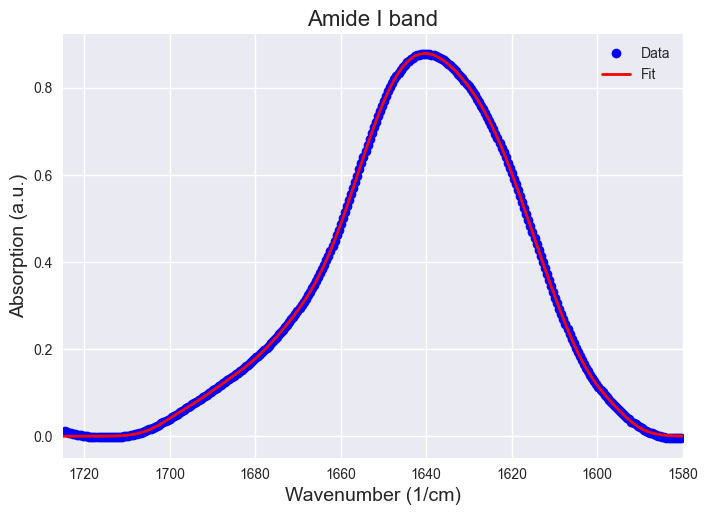

In [29]:
plt.plot(corrected_data.wavenumber, corrected_data.absorption, 'bo', linewidth=2, label='Data')
plt.plot(xfit, yfit, 'r-', linewidth=2, label='Fit')
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Amide I band', **titleFonts)
plt.grid(True)
plt.xlim([amide_band_limit[1], amide_band_limit[0]])
plt.legend()
plt.show()

In [30]:
peak_colors = ['c', 'c', 'c', 'm', 'y', 'c', 'c']
peak_labels = [r'$\beta$-Sheet', '_no_', '_no_',r'$\alpha$-Helix/Random Coil', r'$\beta$-Turn', '_no_', '_no_']
ycolors=['r', 'g', 'b', 'm', 'c', 'y', 'k']

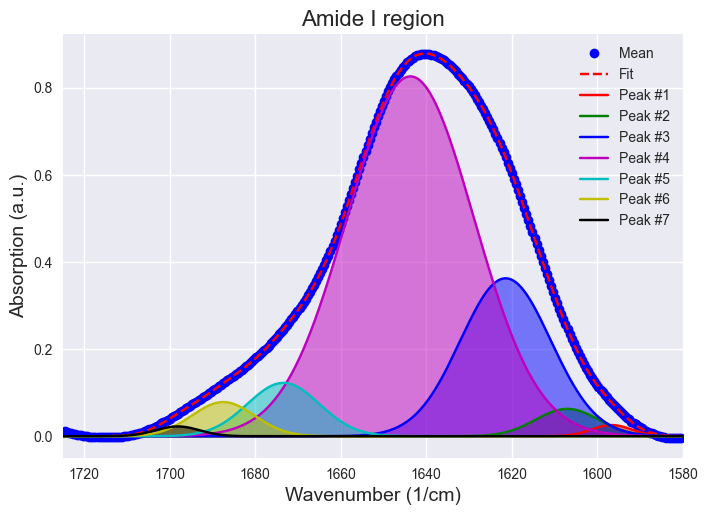

In [31]:
# Plotting separated peaks
plt.plot(corrected_data.wavenumber, corrected_data.absorption, 'bo', alpha=1.0, label='Mean')
plt.plot(xfit, yfit, 'r--', alpha=1.0, label='Fit')

for idx, peak in enumerate(separate_peaks):
    plt.plot(xfit, peak, label=f"Peak #{idx+1}", color=ycolors[idx], alpha=1.0)
    plt.fill_between(xfit, peak.min(), peak, color=ycolors[idx], alpha=0.5)

plt.xlim(amide_band_limit[1], amide_band_limit[0])
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Amide I region', **titleFonts)
plt.legend()
plt.show()

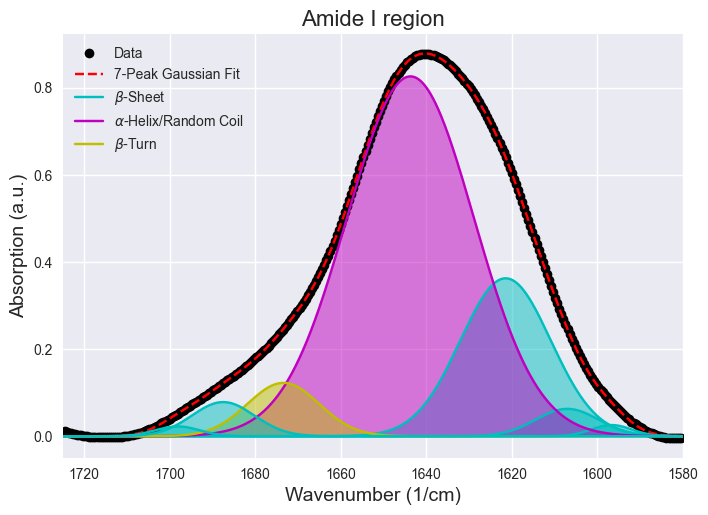

In [32]:
# Labels according to the structure

plt.plot(corrected_data.wavenumber, corrected_data.absorption, 'ko', alpha=1.0, label='Data')
plt.plot(xfit, yfit, 'r--', alpha=1.0, label='7-Peak Gaussian Fit')

for idx, peak in enumerate(separate_peaks):
    plt.plot(xfit, peak, label=peak_labels[idx], color=peak_colors[idx], alpha=1.0)
    plt.fill_between(xfit, peak.min(), peak, color=peak_colors[idx], alpha=0.5)

plt.xlim(amide_band_limit[1], amide_band_limit[0])
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Amide I region', **titleFonts)
plt.legend()
plt.show()

In [33]:
fitted_peaks = []

for i in range(0, len(popt),3):
    fitted_peaks.append(popt[i+1:i+2])
#fitted_peaks = list(fitted_peaks)
print(fitted_peaks)

[array([1596.61109867]), array([1606.99134193]), array([1621.40143223]), array([1643.66311223]), array([1673.38111192]), array([1687.45256361]), array([1698.09539685])]


In [34]:
fitted_peaks[0][0]

np.float64(1596.6110986713406)

In [35]:
peak_diff = []

for i in range(len(peaks)):
    err = abs(peaks[i] - fitted_peaks[i][0])
    peak_diff.append(err)

for elm in peak_diff:
    print(elm)

12.388901328659358
14.008658068334398
9.5985677700221
6.336887771418333
0.381111919695968
7.547436387624657
4.904603145355395


## Tryint to impose lower and upper bounds

In [36]:
print([elm for elm in initial_guess])

[1, 1609, 2, 1, 1621, 2, 1, 1631, 2, 1, 1650, 2, 1, 1673, 2, 1, 1695, 2, 1, 1703, 2]


In [37]:
lower_bounds = []
for peak in peaks:
    lower_bounds.append(0)
    lower_bounds.append(peak - 2)
    lower_bounds.append(0)

print(lower_bounds)

[0, 1607, 0, 0, 1619, 0, 0, 1629, 0, 0, 1648, 0, 0, 1671, 0, 0, 1693, 0, 0, 1701, 0]


In [38]:
upper_bounds = []
for peak in peaks:
    upper_bounds.append(np.inf)
    upper_bounds.append(peak + 2)
    upper_bounds.append(np.inf)

print(upper_bounds)
print(f"Length of bounds arrays: {len(upper_bounds)}")

[inf, 1611, inf, inf, 1623, inf, inf, 1633, inf, inf, 1652, inf, inf, 1675, inf, inf, 1697, inf, inf, 1705, inf]
Length of bounds arrays: 21


In [39]:
def new_seven_gaussian(x, *params):
    assert len(params) == 21

    y = np.zeros_like(x)
    
    for i in range(len(peaks)):
        A = params[3*i]
        pk = params[3*i + 1]
        wid = params[3*i + 2]

        single = A * np.exp(-(x - pk)**2 / (2 * wid**2))
        y += single
    return y

In [40]:
popt, pcov = curve_fit(wrapFunction, corrected_data.wavenumber, corrected_data.absorption, \
                       p0=initial_guess, bounds=(lower_bounds, upper_bounds))

In [41]:
for elm in popt:
    print(elm)

0.12643165908480763
1607.0000078867624
8.877053673394538
0.18843998751013358
1619.0000032432795
8.142479360784359
0.5588373624199034
1630.8056457156247
11.183339566125685
0.6023228277812057
1648.0000987431602
11.140461955535804
0.2029934015154716
1671.764645657276
12.556411589641367
0.03679118032904952
1693.000001618156
6.627191690916908
0.0033542413538534223
1701.3731703071346
2.478314109396346


In [42]:
del yfit, separate_peaks

In [43]:
yfit, separate_peaks = seven_gaussian(xfit, *popt)

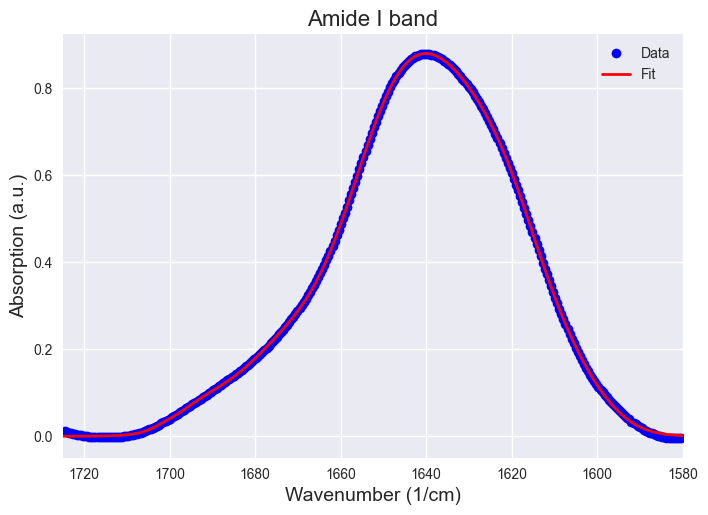

In [44]:
plt.plot(corrected_data.wavenumber, corrected_data.absorption, 'bo', linewidth=2, label='Data')
plt.plot(xfit, yfit, 'r-', linewidth=2, label='Fit')
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Amide I band', **titleFonts)
plt.grid(True)
plt.xlim([amide_band_limit[1], amide_band_limit[0]])
plt.legend()
plt.show()

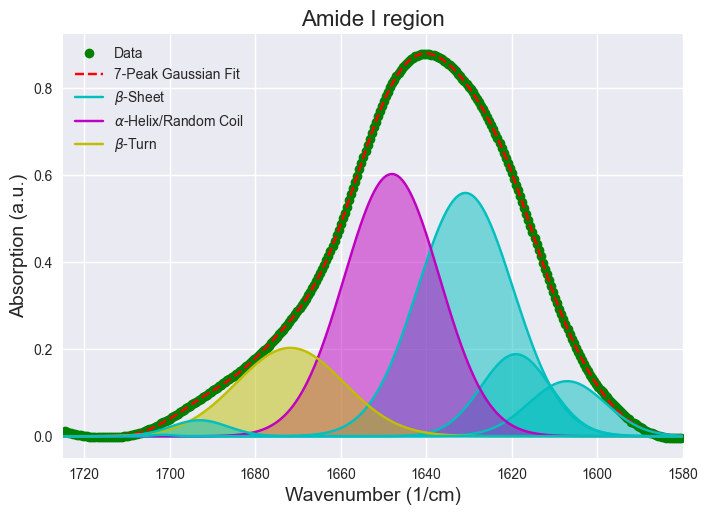

In [45]:
# Labels according to the structure

plt.plot(corrected_data.wavenumber, corrected_data.absorption, 'go', alpha=1.0, label='Data')
plt.plot(xfit, yfit, 'r--', alpha=1.0, label='7-Peak Gaussian Fit')

for idx, peak in enumerate(separate_peaks):
    plt.plot(xfit, peak, label=peak_labels[idx], color=peak_colors[idx], alpha=1.0)
    plt.fill_between(xfit, peak.min(), peak, color=peak_colors[idx], alpha=0.5)

plt.xlim(amide_band_limit[1], amide_band_limit[0])
plt.xlabel('Wavenumber (1/cm)', **axisFonts)
plt.ylabel('Absorption (a.u.)', **axisFonts)
plt.title('Amide I region', **titleFonts)
plt.legend()
plt.show()

In [46]:
new_fitted_peaks = []

for i in range(0, len(popt),3):
    new_fitted_peaks.append(popt[i+1:i+2])
print(new_fitted_peaks)

[array([1607.00000789]), array([1619.00000324]), array([1630.80564572]), array([1648.00009874]), array([1671.76464566]), array([1693.00000162]), array([1701.37317031])]


In [47]:
for (elm1, elm2) in zip(fitted_peaks, new_fitted_peaks):
    print(elm1, elm2)

[1596.61109867] [1607.00000789]
[1606.99134193] [1619.00000324]
[1621.40143223] [1630.80564572]
[1643.66311223] [1648.00009874]
[1673.38111192] [1671.76464566]
[1687.45256361] [1693.00000162]
[1698.09539685] [1701.37317031]


## Calculating areas

In [48]:
from scipy import integrate

In [49]:
splitted_popt = [popt[i:i+3] for i in range(0, len(popt), 3)]
splitted_popt = [tuple(sub) for sub in splitted_popt]
print(splitted_popt)

[(np.float64(0.12643165908480763), np.float64(1607.0000078867624), np.float64(8.877053673394538)), (np.float64(0.18843998751013358), np.float64(1619.0000032432795), np.float64(8.142479360784359)), (np.float64(0.5588373624199034), np.float64(1630.8056457156247), np.float64(11.183339566125685)), (np.float64(0.6023228277812057), np.float64(1648.0000987431602), np.float64(11.140461955535804)), (np.float64(0.2029934015154716), np.float64(1671.764645657276), np.float64(12.556411589641367)), (np.float64(0.03679118032904952), np.float64(1693.000001618156), np.float64(6.627191690916908)), (np.float64(0.0033542413538534223), np.float64(1701.3731703071346), np.float64(2.478314109396346))]


In [50]:
def single_gaussian(x, amp, cen, wid):
    y = amp * np.exp(-(x - cen)**2 / (2 * wid**2))
    return y

In [57]:
quad_areas = []

for idx, peak in enumerate(separate_peaks):
    amplitude, center, width = splitted_popt[idx][0], splitted_popt[idx][1], splitted_popt[idx][2]
    print(amplitude, center, width)
    area = integrate.quad(single_gaussian, xfit[0], xfit[1], args=(amplitude, center, width))
    quad_areas.append(area)



0.12643165908480763 1607.0000078867624 8.877053673394538
0.18843998751013358 1619.0000032432795 8.142479360784359
0.5588373624199034 1630.8056457156247 11.183339566125685
0.6023228277812057 1648.0000987431602 11.140461955535804
0.2029934015154716 1671.764645657276 12.556411589641367
0.03679118032904952 1693.000001618156 6.627191690916908
0.0033542413538534223 1701.3731703071346 2.478314109396346


In [59]:
for elm in quad_areas:
    print(elm[0])

0.00012602952520285971
2.024798118017834e-07
1.8815179219645137e-06
5.028413808529363e-10
5.2773989933203146e-14
3.0932465219275024e-66
0.0


In [54]:
helix_area = quad_areas[3][0]
turn_area = quad_areas[4][0]
sheet_area = quad_areas[0][0] + quad_areas[1][0] + quad_areas[2][0] + quad_areas[5][0] + quad_areas[6][0]

In [55]:
print(f"Total area of A-Helices: {helix_area}")
print(f"Total area of B-Sheets: {sheet_area}")
print(f"Total area of B-Turns: {turn_area}")

Total area of A-Helices: 5.028413808529363e-10
Total area of B-Sheets: 0.000128113522936626
Total area of B-Turns: 5.2773989933203146e-14


In [56]:
total_area = helix_area + turn_area + sheet_area
print(total_area)

0.00012811402583078085


In [61]:
# Calculating the area with S = amp * wid / sqrt(2pi)

new_areas = []
cst = 1 / (np.sqrt(2*np.pi))

for i in range(0, len(popt), 3):
    ampl = popt[i]
    width = popt[i+2]
    new_area = ampl * width / cst
    new_areas.append(new_area)

In [62]:
for elm in new_areas:
    print(elm)

2.8132907411638866
3.846091989808094
15.665594481214534
16.819863116777753
6.389066350262025
0.6111716319723203
0.02083725912733762


In [65]:
new_helix_area = new_areas[3]
new_turn_area = new_areas[4]
new_sheet_area = new_areas[0] + new_areas[1] + new_areas[2] + new_areas[5] + new_areas[6]

In [69]:
print(f"Total area of A-Helices: {new_helix_area:.2f}")
print(f"Total area of B-Sheets: {new_sheet_area:.2f}")
print(f"Total area of B-Turns: {new_turn_area:.2f}")

Total area of A-Helices: 16.82
Total area of B-Sheets: 22.96
Total area of B-Turns: 6.39


In [70]:
total_area = new_helix_area + new_turn_area + new_sheet_area
print(total_area)

46.16591557032595


In [71]:
helix_percent = (new_helix_area / total_area) * 100
sheet_percent = (new_sheet_area / total_area) * 100
turn_percent = (new_turn_area / total_area) * 100

In [74]:
print(f"A-Helix percentage: {helix_percent:.2f}")
print(f"B-Sheet percentage: {sheet_percent:.2f}")
print(f"B-Turn percentage: {turn_percent:.2f}")

A-Helix percentage: 36.43
B-Sheet percentage: 49.73
B-Turn percentage: 13.84


In [85]:
struct_dict = {r'$\beta$-Turn' : turn_percent, r'$\alpha$-Helix/Random Coil' : helix_percent, \
               r'$\beta$-Sheet' : sheet_percent}
bar_colors = ['y', 'm', 'c']
bar_width=0.5
bottom = np.zeros(len(bar_colors))
x = 'Sample'

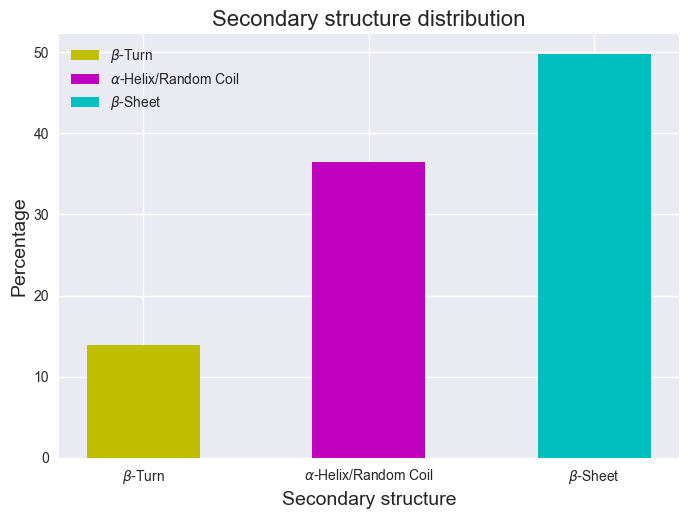

In [89]:
# Bar plot

for idx, (struc, val) in enumerate(struct_dict.items()):
    plt.bar(struc, val, color=bar_colors[idx], width=bar_width, label=struc)
plt.xlabel('Secondary structure', **axisFonts)
plt.ylabel('Percentage', **axisFonts)
plt.title('Secondary structure distribution', **titleFonts)
plt.legend()
plt.show()

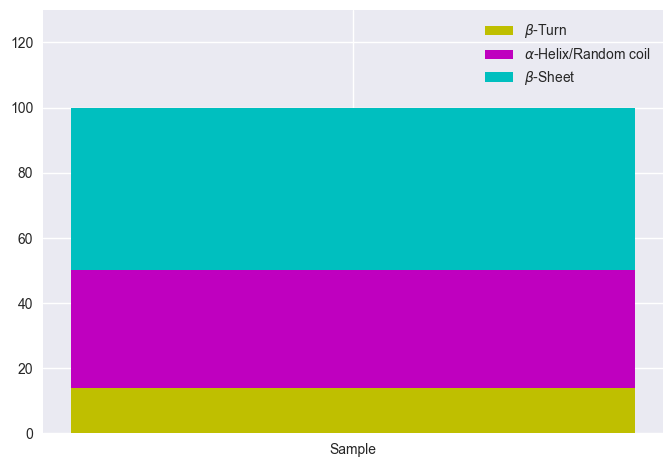

In [84]:
plt.bar(x, turn_percent, color='y', width=bar_width, label=r'$\beta$-Turn')
plt.bar(x, helix_percent, bottom = turn_percent, color='m', width=bar_width, label=r'$\alpha$-Helix/Random coil')
plt.bar(x, sheet_percent, bottom = turn_percent + helix_percent, color='c', width=bar_width, label=r'$\beta$-Sheet')
plt.ylim([0,130])
plt.legend()
plt.show()